In [7]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import MultiStepLR
from torch import optim
import pickle
from matplotlib import pyplot as plt
from libs_unet.models import unet_002
from libs_unet.training.libs_train import train_loop, test_loop
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter
import datetime
datapath = "./data/"

In [8]:
#Leverage PyTorch native Dataset and DataLoader 
#Define Train/Test sets from 20 element data samples
with open(datapath + 'training/10k_nomods.pickle', 'rb') as f:
    fracs = pickle.load(f)
    wave = pickle.load(f)
    x_data = pickle.load(f)
    y_data = pickle.load(f)

#create dataset of single spectrum to see if model can learn it
#input needs a placeholder "channel" dimension since single channel
#learned labels already has max_z + 2 channels from spec_array
#data has to match weights which default to float() so cast data as same
scale_factor = 1
x_data = torch.tensor(x_data[0, None, :].astype('float32'))
x_data = x_data[None,:,:]
y_data = torch.tensor(y_data[0,:,:].astype('float32'))
y_data = y_data[None,:,:]
spec_ds = TensorDataset(scale_factor * x_data, scale_factor * y_data)
#batch sizes
train_bs = 1
train_dl = DataLoader(spec_ds, batch_size=train_bs)
#

In [12]:
#set parameters
el_count = 20 #first n elements used to construct model
wl_points = 760 #number of wavelength point measurements in data
learning_rate = 1 #There is a schedule to reduce as loss plateaus
lr_patience = 1e6
lr_cooldown = 10
lr_thresh = 0.01
epochs = 40000

#Initialize and run
model = unet_002.LIBSUNet(el_count, wl_points)
loss_fn = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
lr_scheduler = MultiStepLR(optimizer, milestones=[1e4, 2e4, 3e4], gamma=0.1)
now_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S') #  now 
writerpath = Path('./runs/'+now_time)
writer = SummaryWriter(writerpath)
#add model to tensorboard
#writer.add_graph(model,train_ds)
prior_lr = learning_rate
for t in range(epochs):
    if optimizer.param_groups[0]['lr'] != prior_lr:
        print(f"Epoch {t+1}, learning rate {optimizer.param_groups[0]['lr']}\n-------------------------------")
        prior_lr = optimizer.param_groups[0]['lr']
    tr_loss = train_loop(train_dl, model, loss_fn, optimizer, writer, t+1, log_interval=1, debug=False)
    lr_scheduler.step()
print("Done!") #loss asymptotes to 1.81e-6 

#cleanup
writer.flush()
writer.close()


Epoch 10001, learning rate 0.1
-------------------------------
Epoch 20001, learning rate 0.010000000000000002
-------------------------------
Epoch 30001, learning rate 0.0010000000000000002
-------------------------------
Done!


In [ ]:
#Fitting a single spectrum achieves MSELoss of 2.37e-6
#Compare this to the variance of the the true y of the sample which is MSE if simply the mean is predicted for all points
#The loss would need to be less than the variance to improve on a prediction of 1/(22*760) for each element of y
torch.var(y_data) #tensor(1.8897e-06)

sum x: 1.0
H: 0.869131
B: 0.002093
F: 0.127832
Ar: 0.000944


/var/folders/q6/v3v7zg9947s0tjqygn5m8l6r0000gn/T/ipykernel_81076/1305029862.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2) = plt.subplots(1, 2)


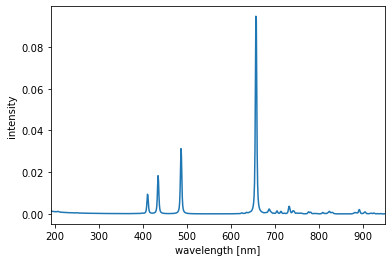

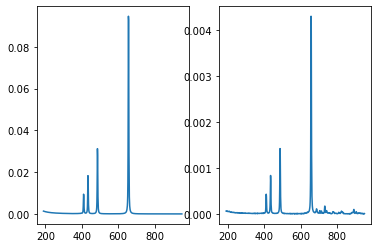

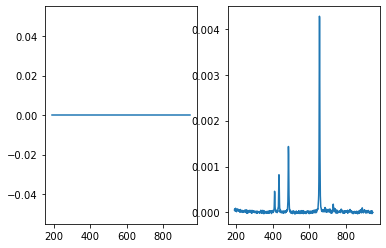

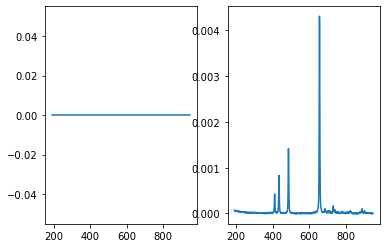

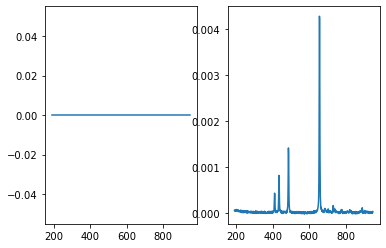

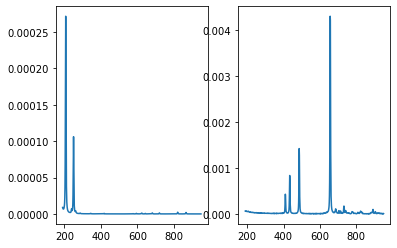

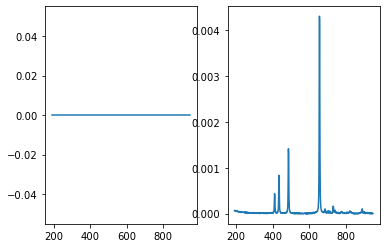

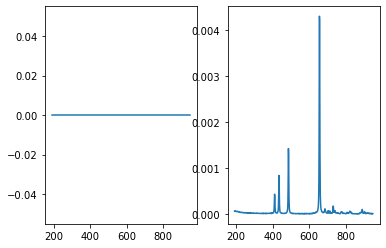

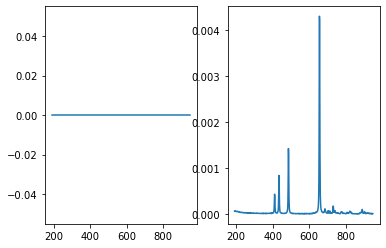

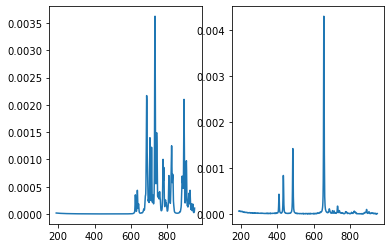

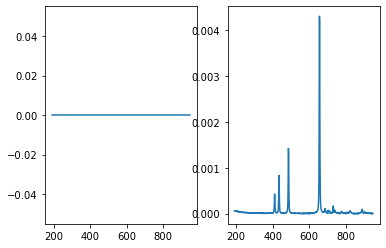

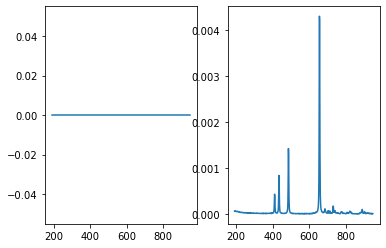

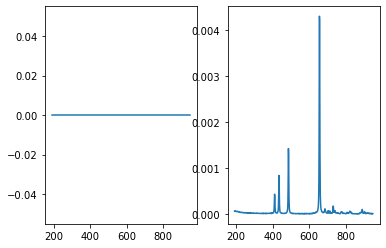

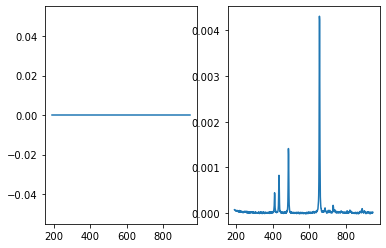

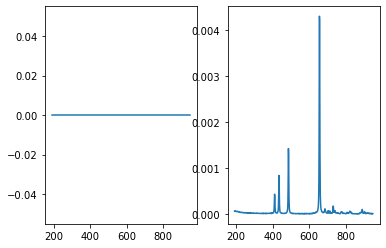

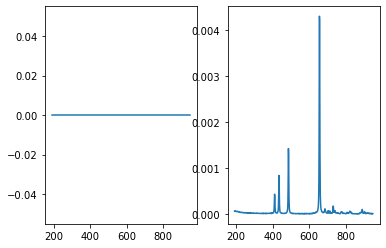

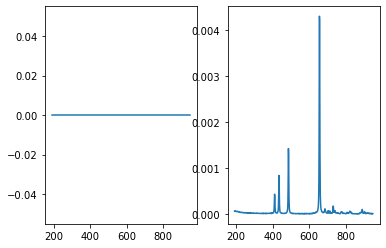

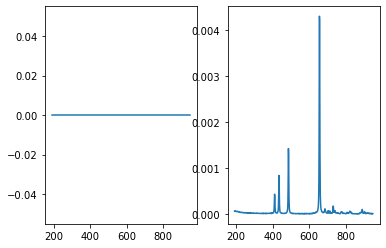

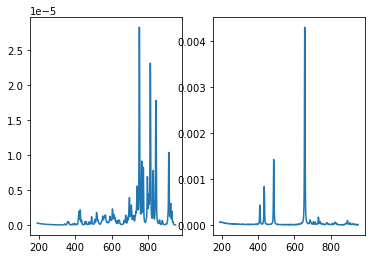

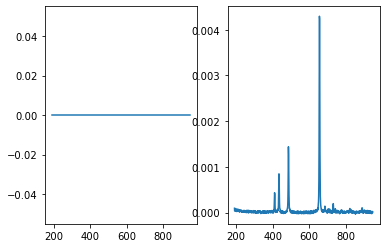

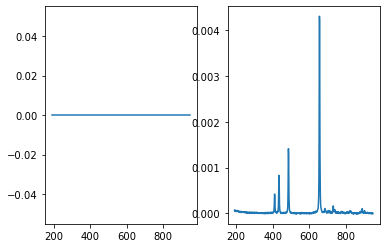

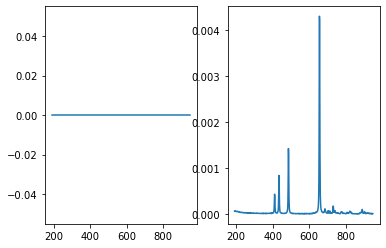

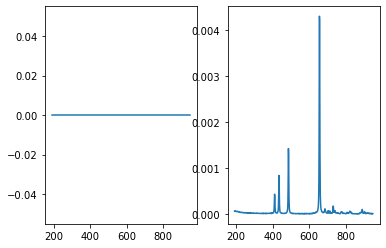

In [13]:
#look at the predicted vs. reference spectra
i_samp = 0 #vary up to 9999
x_sample = x_data[i_samp][None, :, :] #need correct dimensions with batch for prediction
y_sample = y_data[i_samp].detach().numpy() #[22][760] # 20+2 (el + art + noi) spectra
elem_symb = np.loadtxt(datapath + "abundance/elements_94.csv", dtype=str)
#composite spectra and components
print(f"sum x: {torch.sum(x_sample[0][0])}")
#show the element fractions
for i in range(20):
    frac = np.sum(y_sample[i])
    if frac > 0:
        print(f"{elem_symb[i]}: {frac:>4f}")
        
wave = np.arange(190,950)
#first plot the composite input spectrum we're trying to decompose
plt.plot(wave, x_sample[0][0])
plt.xlabel('wavelength [nm]')
plt.ylabel('intensity')
plt.xlim([190, 950])
plt.show

#prediction
model.eval()
with torch.no_grad():
    pred = model(x_sample)
    y_pred = pred[0].detach().numpy() #[22][760] corresponding predictions for y_sample

    #https://matplotlib.org/3.5.0/tutorials/introductory/usage.html#the-object-oriented-interface-and-the-pyplot-interface
    def pred_plot(ax, data1, data2, param_dict):
        out = ax.plot(data1, data2, **param_dict)
        return out
    for i in range(22):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        pred_plot(ax1, wave, y_sample[i], {})
        pred_plot(ax2, wave, y_pred[i], {})